# Modelling trend with tree based models

Tree-based models, including decision trees, random forests and gradient boosting machines (GBMs), are known for their effectiveness and widespread use in various machine learning applications. However, they have limitations when it comes to extrapolation, i.e. making predictions or estimates beyond the range of observed data. This limitation becomes particularly critical when forecasting time series data with a trend. Because these models lack the ability to predict values beyond the observed range during training, their forecasted values may deviate from the underlying trend.

## Libraries

In [2]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from lineartree import LinearForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Data

Train dates : 1991-07-01 00:00:00 --- 2002-12-01 00:00:00  (n=138)
Test dates  : 2003-01-01 00:00:00 --- 2008-06-01 00:00:00  (n=66)


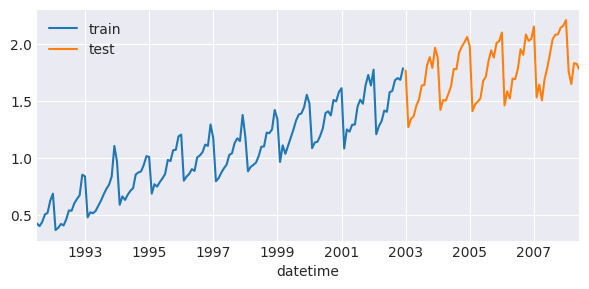

In [3]:
# Download data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/'
    'data/h2o.csv'
)
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
trend = 0.005 * np.arange(len(data))
data = data + trend
data = data.sort_index()

# Data partition train-test
# ==============================================================================
end_train = '2002-12-31 23:59:00'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  " 
    f"(n={len(data.loc[:end_train])})")
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
ax.legend();

## Forecasting with tree-base models

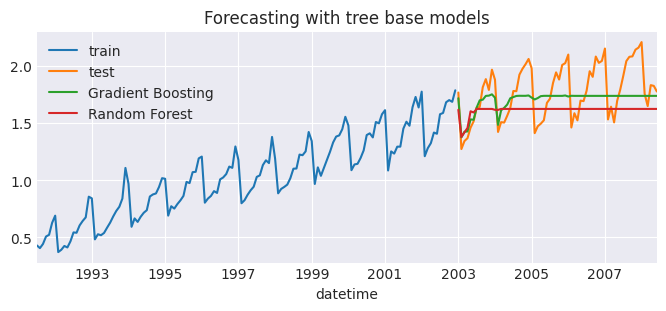

In [4]:
# Forecaster Random Forest
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123,),
                 lags      = 24
             )

forecaster.fit(y=data.loc[:end_train])
predictions_rf = forecaster.predict(steps=len(data.loc[end_train:]))

# Forecaster Gradient Boosting
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = HistGradientBoostingRegressor(random_state=123, max_iter=50),
                 lags      = 24
             )

forecaster.fit(y=data.loc[:end_train])
predictions_gb = forecaster.predict(steps=len(data.loc[end_train:]))

# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_rf.plot(ax=ax, label='Gradient Boosting')
predictions_gb.plot(ax=ax, label='Random Forest')
ax.set_title('Forecasting with tree base models')
ax.legend();

## Forecasting with liner models

Unlike tree-based models, linear models can extrapolate beyond the observed range during training, allowing them to capture and extend the underlying trend of the time series. However, it's important to note that linear models have limitations in capturing non-linear trends and complex patterns inherent in some time series data. They assume linearity and may struggle to accurately model complex non-linear behaviour.

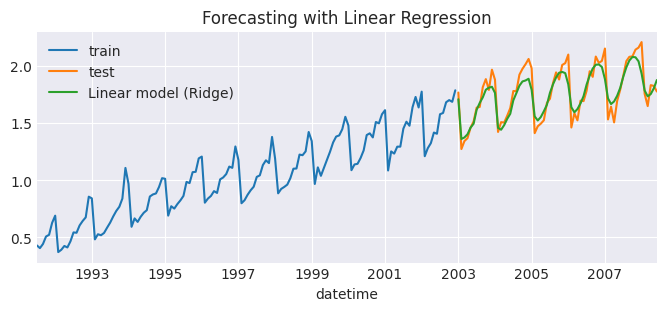

In [5]:
# Forecaster Linear Regression (Ridge)
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = Ridge(random_state=123),
                 lags      = 24
             )

forecaster.fit(y=data.loc[:end_train])
predictions_ridge = forecaster.predict(steps=len(data.loc[end_train:]))

# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_ridge.plot(ax=ax, label='Linear model (Ridge)')
ax.set_title('Forecasting with Linear Regression')
ax.legend();


## Linear tree models

Linear Trees combine the learning ability of Decision Tree with the predictive and explicative power of Linear Models. Like in tree-based algorithms, the data are split according to simple decision rules. The goodness of slits is evaluated in gain terms fitting Linear Models in the nodes. This implies that the models in the leaves are linear instead of constant approximations like in classical Decision Trees.

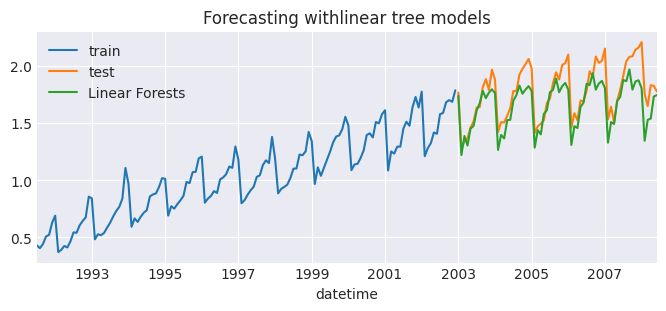

In [6]:

# Forecaster Linear Forests
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LinearForestRegressor(base_estimator=LinearRegression()),
                 lags      = 24
             )

forecaster.fit(y=data.loc[:end_train])
predictions_linear_rf = forecaster.predict(steps=len(data.loc[end_train:]))

# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_linear_rf.plot(ax=ax, label='Linear Forests')
ax.set_title('Forecasting withlinear tree models')
ax.legend();

## Diferenciating the time series

Differentiation of a time series is a technique used to remove the trend in a tiem series. This transformation can be beneficial when using tree-based models for forecasting, as these models are not able to campture the trend. The differentiation process involves computing the differences between consecutive observations in the time series. 

Althought there are other method to remove the trend, for example using a moving average, differencing is the most straightforward to reverse once you have the predictions of the model. You can easily undo the differencing process by cumulatively summing the differenced values.

Keep in mind that reversing the trend removal process assumes the trend remains constant beyond the training data. If the underlying trend is expected to change significantly in the forecasted period, the reverse process may not be accurate.

In [7]:
class TimeSeriesDifferentiator():
    def __init__(self, order=1):
        self.initial_value = None
        self.last_value = None
        self.order = order

    def fit(self, x):
        self.first_training_value = x.iloc[:1]
        self.last_training_value = x.iloc[-1:]
        self.training_data = x.copy()

    def transform(self, x):
        diff = x.diff().dropna()
        return diff

    def inverse_transform_train_data(self, x, is_train_data=False):
        cum_sum = x.cumsum()
        inverse = cum_sum + self.first_training_value.to_numpy()[0]
        inverse = pd.concat([self.first_training_value, inverse])

        return inverse

    def inverse_transform_new_data(self, x):
        first_index = x.index[0]
        cum_sum = x.cumsum()
        inverse = cum_sum + self.last_training_value.to_numpy()[0]
        inverse = pd.concat([self.last_training_value, inverse])
        print(self.last_training_value)
        return inverse


In [8]:
y = pd.Series(np.arange(10))
y_train = y.iloc[:5]
y_test = y.iloc[5:]
transformer = TimeSeriesDifferentiator(order=1)
transformer.fit(y)
y_diff = transformer.transform(y)
y_train_diff = y_diff.iloc[:5]
y_test_diff = y_diff.iloc[5:]

y_train_inverse = transformer.inverse_transform_train_data(y_train_diff)
print("Training data")
print(y_train)
print("Training data diff")
print(y_train_diff)
print("Training data inverse")
print(y_train_inverse)

print("New data diff")
print(y_test_diff)
y_test_inverse = transformer.inverse_transform_new_data(y_test_diff)
print("New data inverse")
print(y_test_inverse)

Training data
0    0
1    1
2    2
3    3
4    4
dtype: int64
Training data diff
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
dtype: float64
Training data inverse
0    0.0
1    1.0
2    2.0
3    3.0
4    4.0
5    5.0
dtype: float64
New data diff
6    1.0
7    1.0
8    1.0
9    1.0
dtype: float64
9    9
dtype: int64
New data inverse
9     9.0
6    10.0
7    11.0
8    12.0
9    13.0
dtype: float64


Train dates : 1991-08-01 00:00:00 --- 2002-12-01 00:00:00  (n=138)
Test dates  : 2003-01-01 00:00:00 --- 2008-06-01 00:00:00  (n=66)


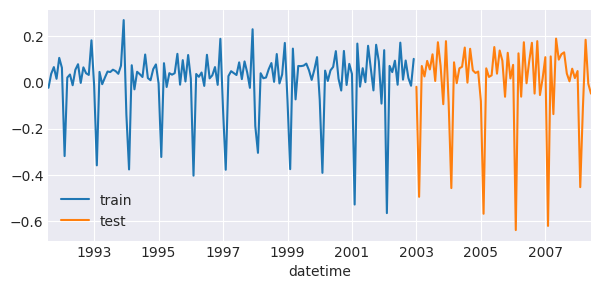

In [9]:
# Data differentiation
# ==============================================================================
data_diff = TimeSeriesDifferentiator(order=1).transform(data)
data_diff = data_diff.dropna()

# Data partition train-test
# ==============================================================================
print(
    f"Train dates : {data_diff.index.min()} --- {data_diff.loc[:end_train].index.max()}  " 
    f"(n={len(data.loc[:end_train])})")
print(
    f"Test dates  : {data_diff.loc[end_train:].index.min()} --- {data_diff.index.max()}  "
    f"(n={len(data_diff.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_diff.loc[:end_train].plot(ax=ax, label='train')
data_diff.loc[end_train:].plot(ax=ax, label='test')
ax.legend();


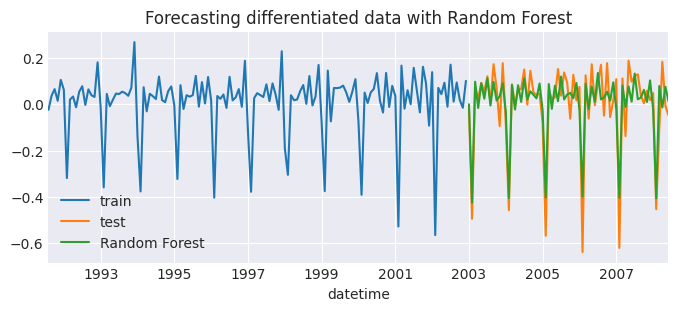

In [10]:
# Forecaster Random Forest
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 24,
                 #transformer_y=TimeSeriesDifferentiator(order=1)
             )

forecaster.fit(y=data_diff.loc[:end_train])
predictions_rf = forecaster.predict(steps=len(data_diff.loc[end_train:]))

# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
data_diff.loc[:end_train].plot(ax=ax, label='train')
data_diff.loc[end_train:].plot(ax=ax, label='test')
predictions_rf.plot(ax=ax, label='Random Forest')
ax.set_title('Forecasting differentiated data with Random Forest')
ax.legend();


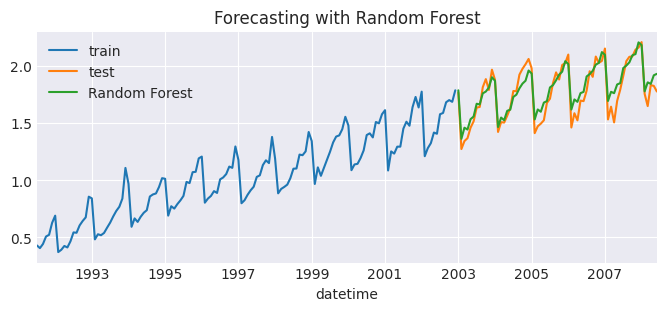

In [11]:
# Inverse differentiation
# ==============================================================================
first_value_train = data.loc[:end_train].iloc[:1]
last_value_train = data.loc[:end_train].iloc[-1:]

data_train_diff_inverse = pd.concat([first_value_train, data_diff.loc[:end_train]]).cumsum()
data_test_diff_inverse = data_diff.loc[end_train:].cumsum() + last_value_train.values[0]
predictions_diff_inverse =predictions_rf.cumsum() + last_value_train.values[0]

# Check that inverse differentiation is correct
pd.testing.assert_series_equal(data_train_diff_inverse, data.loc[:end_train])
pd.testing.assert_series_equal(data_test_diff_inverse, data.loc[end_train:])


fig, ax = plt.subplots(figsize=(8, 3))
data_train_diff_inverse.plot(ax=ax, label='train')
data_test_diff_inverse.plot(ax=ax, label='test')
predictions_diff_inverse.plot(ax=ax, label='Random Forest')
ax.set_title('Forecasting with Random Forest')
ax.legend();

%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>